# Лабораторная на Классификацию |

В ходе этой работы мы проведём классификацию на синтетических данных при помощи логистической регрессии

## Импортируем библиотеки

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## Генерируем данные с распределением в виде "Инь-Ян"

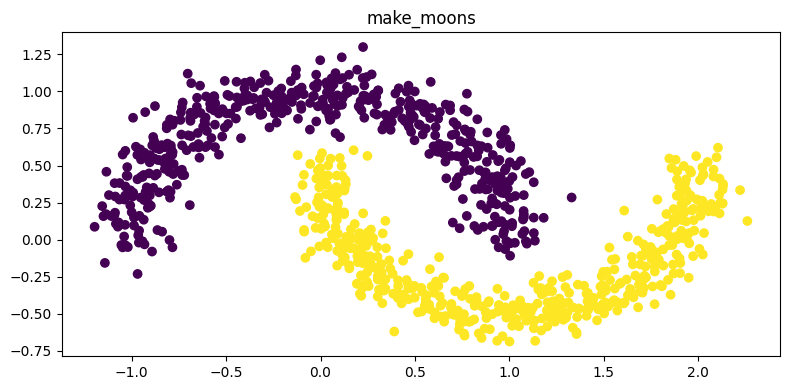

In [2]:
# Сгенерируем 1000 точек в виде Инь-Ян с помощью знакомой нам библиотеки и добавим немного шума
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

X, Y = make_moons(n_samples=1_000, noise=0.1, random_state=41)
ax.scatter(X[:, 0], X[:, 1], c=Y)
ax.set_title("make_moons")

plt.tight_layout()
plt.show()

Как мы видим вышел очень красивый Инь-Ян из данных, теперь попробуем ими воспользоваться для обучения модели (данные синтетические, поэтому обрабатывать их и как либо работать с ними не нужно).

## Разделим данные, проверим разные степени полиномов и выберем лучшую

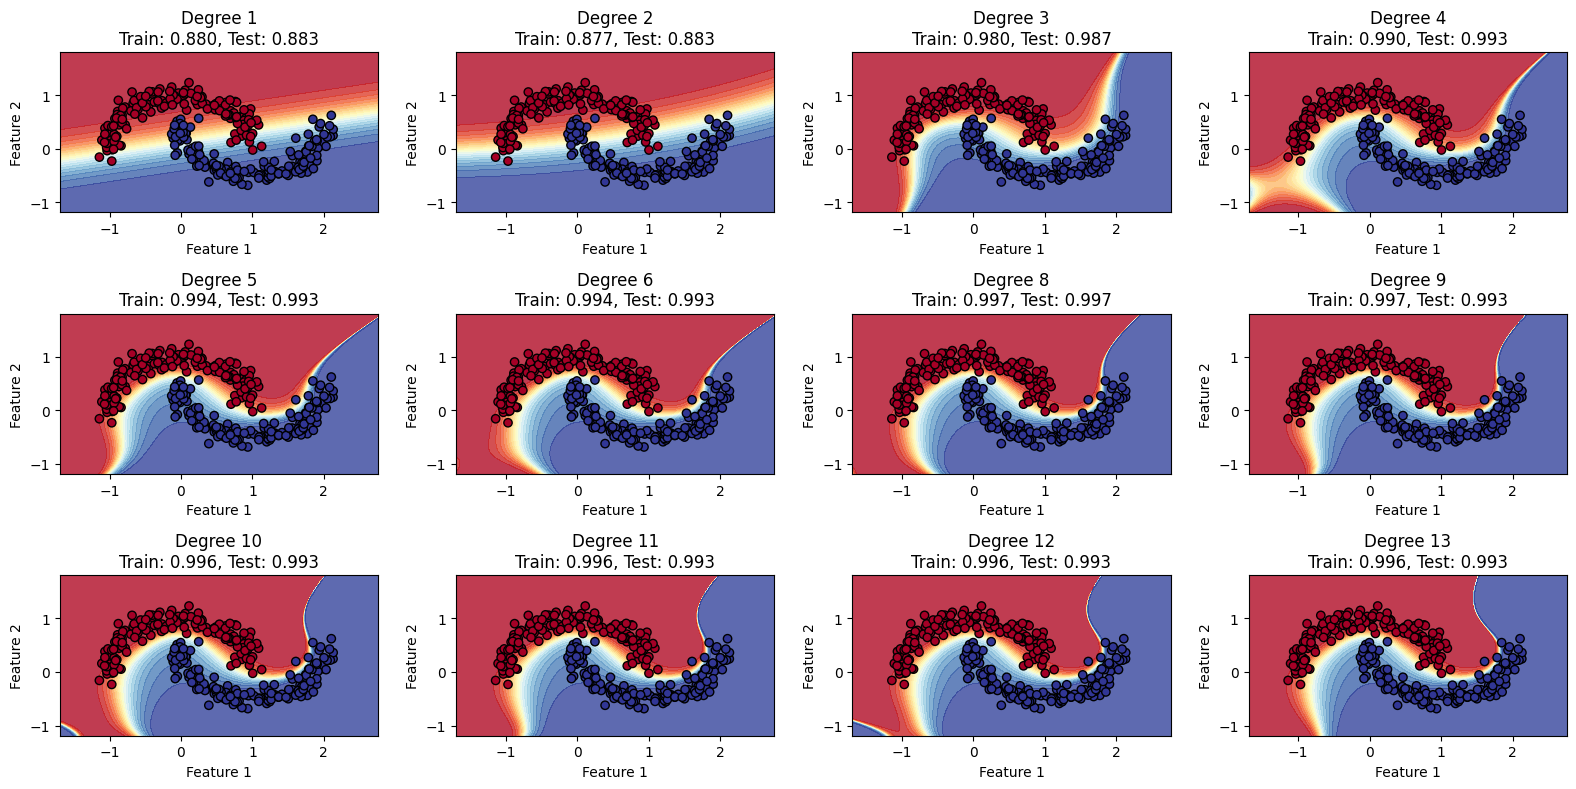

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

degrees = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
results = {}

fig, axes = plt.subplots(3, 4, figsize=(16, 8))
axes = axes.flatten()

for i, degree in enumerate(degrees):
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=1.0,
            max_iter=3000,
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results[degree] = {
        'model': pipeline,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'n_features': pipeline.named_steps['poly'].n_output_features_
    }

    if i < len(axes):
        x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
        y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
        Z = pipeline.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        axes[i].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu, levels=20)
        axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.RdYlBu)
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')
        axes[i].set_title(f'Degree {degree}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')

for i in range(len(degrees), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Судя по accuracy и графикам можно предположить, что оптимальная степень полинома выходит 8, её и используем. Так же заметим, что начиная с 5 степени модель не сильно меняется по метрикам и по визуальному разделению линии.

## Снова обучим модель, но с полиномом 8 степени и посмотрим артефакты модели

Accuracy: 0.9967

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.99      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



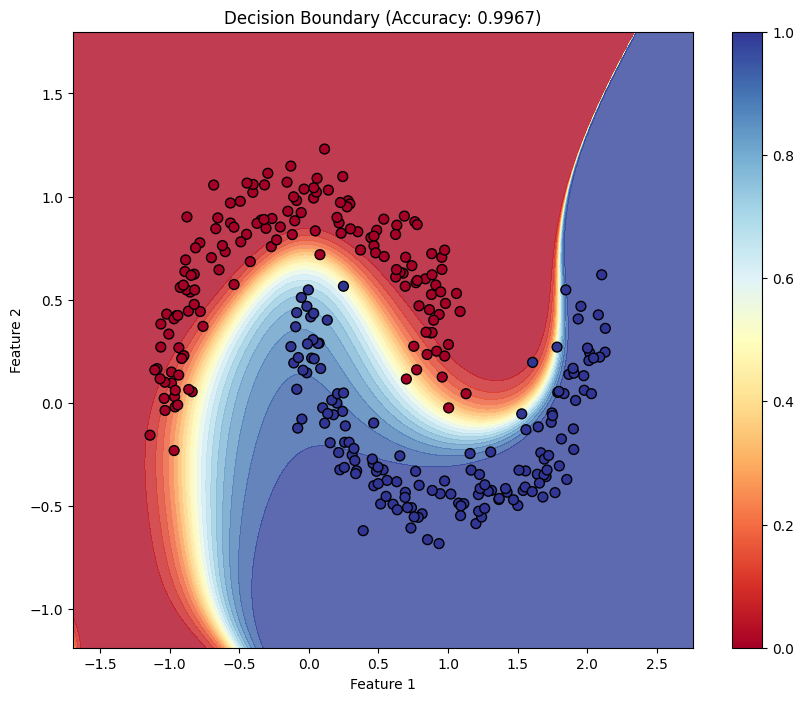

In [28]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=8, include_bias=False)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=1.0, max_iter=5000, random_state=42))
])

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

classifier = pipeline.named_steps['classifier']
coef = classifier.coef_[0]
intercept = classifier.intercept_[0]
weights = np.hstack([intercept, coef])

numbers = np.arange(0, len(weights))
tick_labels = np.array(['w' + str(num) for num in numbers])

fig = go.Figure()
fig.add_trace(go.Bar(x=numbers[weights < 0], y=weights[weights < 0],marker_color='red',name='отрицательные веса'))
fig.add_trace(go.Bar(x=numbers[weights >= 0], y=weights[weights >= 0],marker_color='blue', name='положительные веса'))

fig.update_layout(
    title="Веса модели",
    width=1200,
    height=600,
    template="plotly_dark",
    xaxis=dict(
        tickmode='array',
        tickvals=numbers,
        ticktext=tick_labels,
    )
)

fig.show()

x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = pipeline.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu, levels=20)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.RdYlBu, s=50)
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Decision Boundary (Accuracy: {accuracy:.4f})')
plt.show()


Вышла хорошая модель по визуализации и метрикам (ну так данные сами создали, сами их же и предсказали - много ума и не надо)

## Вывод
Успешно вышло сгенерировать данные вида "Инь-Ян", удалось хорошо классифицировать данные (не удивительно) и показать артефакты лучшей модели (полином 8 степени почти идеально подошёл для такого набора данных). Однако для более "реальных данных" такая модель скорее всего не подойдёт, тк полином 8 степени будет слишком сложный и может переобучиться (это предположение - нужно проверять).